# NP2 channel-map geometry checker (`channel_positions.npy`)

This notebook helps you verify that each probe's Kilosort geometry matches the channel map you intended to use.

It will:
- load `channel_positions.npy` (and optionally `channel_map.npy`),
- plot the physical channel layout,
- summarize x/y spacing statistics,
- estimate a **suggested** `nChannelsIsoDist` range for BombCell.


In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120


## 1) Configure your Kilosort folders

Set one folder per probe (A/C/D etc.). Each folder should contain `channel_positions.npy`.


In [8]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import bombcell as bc

analysis_dir = Path.cwd().resolve()
sys.path.insert(0, str(analysis_dir))
from post_analysis_setup import load_post_analysis_context

CONFIG_FILE = r'C:\Users\user\Documents\github\bombcell\py_bombcell\grant\configs\grant_recording_config_reach15_20260201_session007.json'
RUN_MODE = 'batch'   # batch | single_probe | np20_rerun
TARGET_PROBE = 'B'   # A-F
TARGET_PROBES = ["A",'C','D']   # A-F



In [17]:
ctx = load_post_analysis_context(CONFIG_FILE)
mode_to_roots = {
    'batch': (ctx['DEFAULT_KS_STAGING_ROOT'], ''),
    'np20_rerun': (ctx['NP20_KS_STAGING_ROOT'], ''),
    'single_probe': (ctx['BOMBCELL_KS_SINGLEPROBE_STAGING_ROOT'], ''),
}

staging_root, save_subdir = mode_to_roots[RUN_MODE]
ks_dir = Path(staging_root) / f'kilosort4_{TARGET_PROBE}'
save_path = ks_dir / 'bombcell' / save_subdir

print('ks_dir:', ks_dir)
print('save_path:', save_path)

# load all ks_dir / bombcell results for TARGET_PROBES and place in probe_dirs
probe_letters = TARGET_PROBES if RUN_MODE == 'batch' else [TARGET_PROBE]
probe_dirs = {}
missing_probes = []
for probe in probe_letters:
    ks_dir = Path(staging_root) / f'kilosort4_{probe}'
    save_path = ks_dir 
    probe_dirs[probe] = save_path
    print(f'Loading probe {probe} from ks_dir: {ks_dir}')
    if not save_path.exists():
        print(f'Missing bombcell save_path for probe {probe}: {save_path}')
        missing_probes.append(probe)
        continue
probe_dirs

ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B
save_path: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B\bombcell
Loading probe A from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_A
Loading probe C from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_C
Loading probe D from ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_D


{'A': WindowsPath('H:/Grant/Neuropixels/Kilosort_Recordings/Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00/bombcell/bombcell_DEFAULT/kilosort4_A'),
 'C': WindowsPath('H:/Grant/Neuropixels/Kilosort_Recordings/Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00/bombcell/bombcell_DEFAULT/kilosort4_C'),
 'D': WindowsPath('H:/Grant/Neuropixels/Kilosort_Recordings/Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00/bombcell/bombcell_DEFAULT/kilosort4_D')}

## 2) Helpers

In [18]:
def load_geometry(ks_dir: Path):
    ks_dir = Path(ks_dir)
    pos = np.load(ks_dir / "channel_positions.npy")

    cmap_file = ks_dir / "channel_map.npy"
    if cmap_file.exists():
        cmap = np.load(cmap_file).squeeze()
    else:
        cmap = None

    if pos.ndim != 2 or pos.shape[1] != 2:
        raise ValueError(f"Expected (n_channels,2) channel_positions in {ks_dir}, got {pos.shape}")

    return pos, cmap


def nearest_neighbor_distances(channel_positions):
    cp = np.asarray(channel_positions, dtype=float)
    d = cp[:, None, :] - cp[None, :, :]
    dist = np.sqrt((d**2).sum(axis=2))
    np.fill_diagonal(dist, np.inf)
    return dist.min(axis=1)


def summarize_geometry(channel_positions):
    cp = np.asarray(channel_positions, dtype=float)
    ux = np.unique(np.round(cp[:, 0], 6))
    uy = np.unique(np.round(cp[:, 1], 6))

    dx = np.diff(np.sort(ux)) if ux.size > 1 else np.array([])
    dy = np.diff(np.sort(uy)) if uy.size > 1 else np.array([])
    nn = nearest_neighbor_distances(cp)

    summary = {
        "n_channels": cp.shape[0],
        "n_unique_x": int(ux.size),
        "n_unique_y": int(uy.size),
        "median_dx": float(np.median(dx)) if dx.size else np.nan,
        "median_dy": float(np.median(dy)) if dy.size else np.nan,
        "median_nn_dist": float(np.median(nn)),
        "p90_nn_dist": float(np.percentile(nn, 90)),
    }
    return summary, nn


def suggest_nChannelsIsoDist(summary):
    """
    Heuristic suggestion:
    - sparse maps (large nearest-neighbor spacing) -> larger neighborhood
    - dense maps -> default is often fine
    """
    p90 = summary["p90_nn_dist"]
    if np.isnan(p90):
        return "unknown", "Could not estimate spacing"
    if p90 >= 40:
        return "8-12", "Sparse/interleaved geometry: use more nearby channels"
    if p90 >= 25:
        return "6-8", "Moderately sparse geometry: consider increasing from default 4"
    return "4-6", "Dense geometry: default 4 is usually reasonable"


def plot_geometry(channel_positions, title=""):
    cp = np.asarray(channel_positions)
    fig, ax = plt.subplots(figsize=(5, 9))
    ax.scatter(cp[:, 0], cp[:, 1], s=14)
    ax.set_xlabel("x (um)")
    ax.set_ylabel("y (um)")
    ax.set_title(title)
    ax.grid(alpha=0.2)
    ax.set_aspect('equal')
    plt.show()


## 3) Run geometry checks for all probes


=== A ===
Kilosort folder: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_A
channels: 384
unique x: 8, unique y: 200
median dx: 32.00 um
median dy: 15.00 um
median NN distance: 43.86 um
p90 NN distance: 43.86 um
Suggested nChannelsIsoDist: 8-12 (Sparse/interleaved geometry: use more nearby channels)


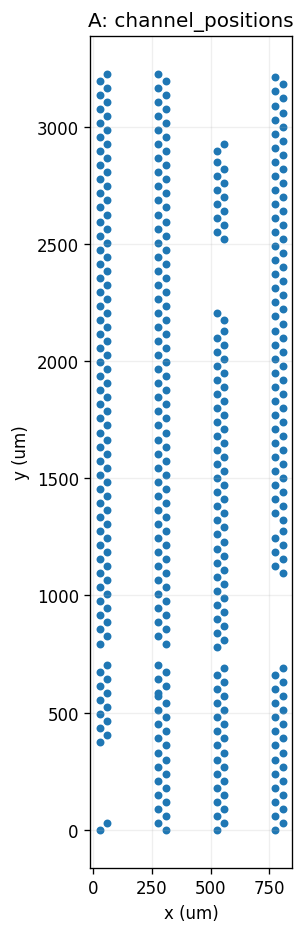


=== C ===
Kilosort folder: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_C
channels: 384
unique x: 8, unique y: 109
median dx: 32.00 um
median dy: 15.00 um
median NN distance: 30.00 um
p90 NN distance: 30.00 um
Suggested nChannelsIsoDist: 6-8 (Moderately sparse geometry: consider increasing from default 4)


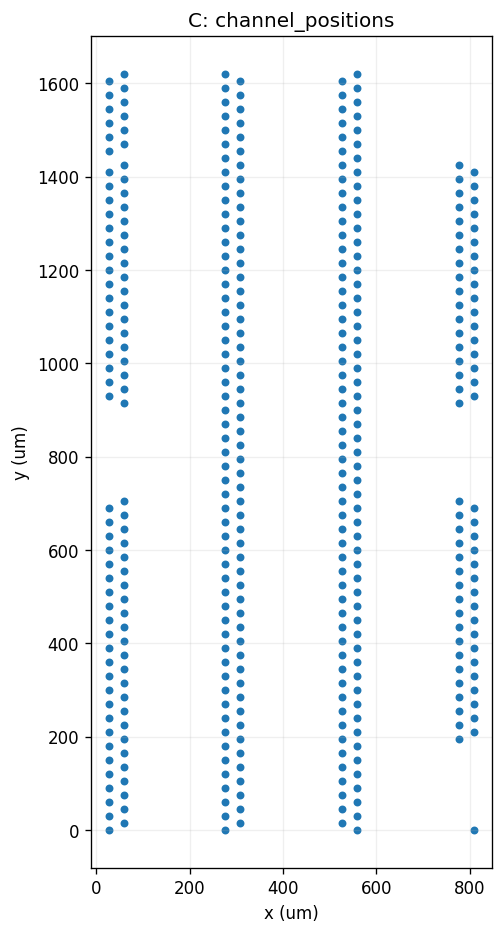


=== D ===
Kilosort folder: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_D
channels: 384
unique x: 8, unique y: 78
median dx: 32.00 um
median dy: 15.00 um
median NN distance: 15.00 um
p90 NN distance: 15.00 um
Suggested nChannelsIsoDist: 4-6 (Dense geometry: default 4 is usually reasonable)


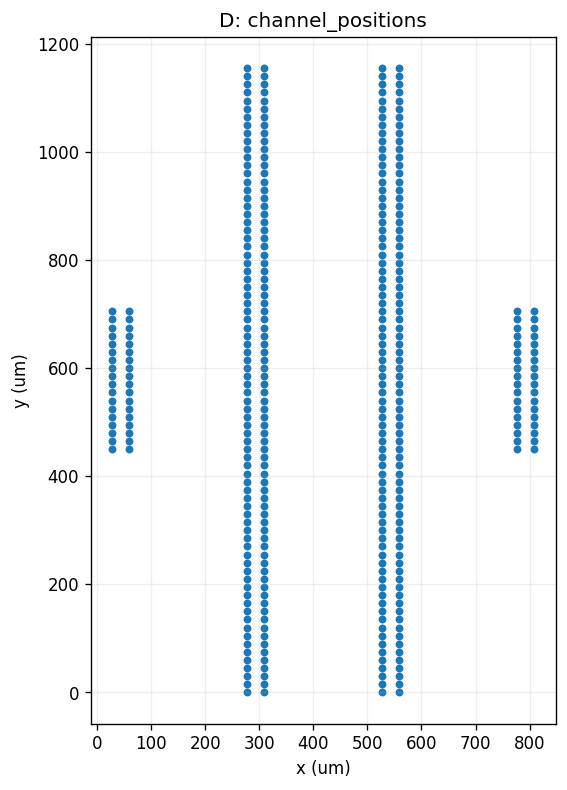

In [19]:
results = {}

for name, ks_dir in probe_dirs.items():
    print(f"\n=== {name} ===")
    if not (ks_dir / "channel_positions.npy").exists():
        print(f"Missing channel_positions.npy: {ks_dir}")
        continue

    channel_positions, channel_map = load_geometry(ks_dir)
    summary, nn = summarize_geometry(channel_positions)
    rec, note = suggest_nChannelsIsoDist(summary)

    results[name] = {
        "ks_dir": ks_dir,
        "summary": summary,
        "nChannelsIsoDist_recommendation": rec,
        "recommendation_note": note,
    }

    print(f"Kilosort folder: {ks_dir}")
    print(f"channels: {summary['n_channels']}")
    print(f"unique x: {summary['n_unique_x']}, unique y: {summary['n_unique_y']}")
    print(f"median dx: {summary['median_dx']:.2f} um")
    print(f"median dy: {summary['median_dy']:.2f} um")
    print(f"median NN distance: {summary['median_nn_dist']:.2f} um")
    print(f"p90 NN distance: {summary['p90_nn_dist']:.2f} um")
    print(f"Suggested nChannelsIsoDist: {rec} ({note})")

    plot_geometry(channel_positions, title=f"{name}: channel_positions")


## 4) Optional: quick comparison table

In [20]:
try:
    import pandas as pd
    rows = []
    for name, info in results.items():
        row = {"probe": name, **info["summary"],
               "nChannelsIsoDist_recommendation": info["nChannelsIsoDist_recommendation"],
               "note": info["recommendation_note"]}
        rows.append(row)
    display(pd.DataFrame(rows).sort_values("probe"))
except Exception as e:
    print("Pandas table skipped:", e)


,probe,n_channels,n_unique_x,n_unique_y,median_dx,median_dy,median_nn_dist,p90_nn_dist,nChannelsIsoDist_recommendation,note
0,A,384,8,200,32.0,15.0,43.863424,43.863424,8-12,Sparse/interleaved geometry: use more nearby c...
1,C,384,8,109,32.0,15.0,30.000000,30.000000,6-8,Moderately sparse geometry: consider increasin...
2,D,384,8,78,32.0,15.0,15.000000,15.000000,4-6,Dense geometry: default 4 is usually reasonable


## How to interpret for your specific NP2 patterns

Given your description:
- **Probe A** (`ON,OFF,OFF,OFF` interleaving): likely sparsest effective local neighborhood → start around **8** (test 8–12).
- **Probe C** (`ON,OFF` interleaving): moderate sparsity → start around **6** (test 6–8).
- **Probe D** (contiguous ON region): densest local neighborhood → default **4** is usually acceptable (test 4–6).

Use the printed spacing stats and a small-unit QC comparison to decide final values.
